In [1]:
from voxel import *

In [2]:
# Calculate coordinates of two atoms in rhombus
# a = 1
# alpha = 45 deg = pi/4
f = 2 * np.sin(np.pi/8)
e = np.cos(np.pi/8)
r = f*np.sqrt(4-f**2)/(4+2*f)

x1 = np.cos(np.pi/8)*(e-r)
y1 = np.sin(np.pi/8)*(e-r)
print(x1, y1)

x2 = np.cos(np.pi/8)*(e+r)
y2 = np.sin(np.pi/8)*(e+r)
print(x2, y2)

0.6173165676349102 0.2557008945919878
1.0897902135516373 0.4514058865945597


In [3]:
# matrix corresponding to unit cell (columns are primitive unit vectors)
A = np.array([
    [1., np.sqrt(0.5)],
    [0., np.sqrt(0.5)]
]) * 3

# atom coordinates
mus = np.array([[x1,y1], [x2, y2]])*3

# standard deviation for the Gaussians
sigma = 0.3

# get the field quantity as function
gauss = get_nD_gaussian(A, mus, sigma, 3)

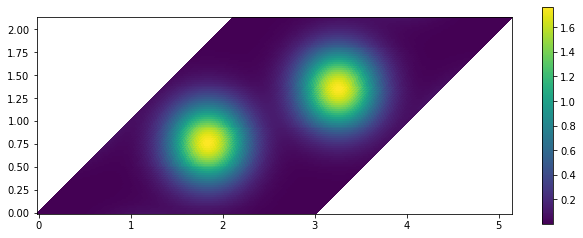

In [4]:
# evaluate the field over the unit cell, n specifies precision
R, SR = bravais_lattice(gauss, A, n=101)
plot_2D_realspace_lattice(A, R, SR)

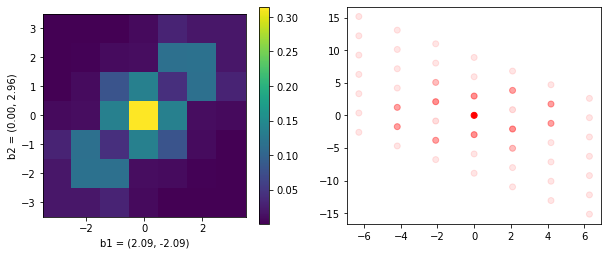

In [5]:
# evaluate field over reciprocal space at integer multiples of the basis vectors of B = 2pi inv(A).T
mx = np.arange(-3,4)
my = np.arange(-3,4)
B, G, SG = reciprocal_lattice(gauss, A, mx, my, n=101) # numerically
plot_2D_reciprocal_lattice(B, mx, my, G, SG)

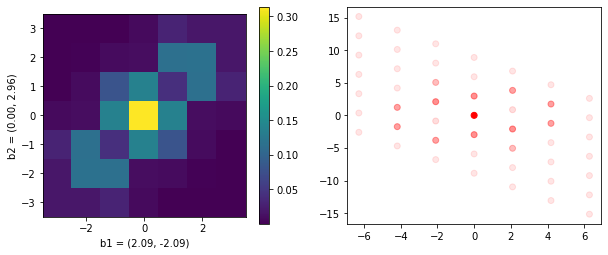

In [6]:
B, G, SG = reciprocal_lattice_gaussian(A, mus, sigma, mx, my) # theoretically
plot_2D_reciprocal_lattice(B, mx, my, G, SG)

## Descriptor

In [7]:
# parameters
L = 12.8
N = 32

In [8]:
width = 2 * np.pi / L * N
width

15.707963267948966

In [9]:
voxel_width = width / N
voxel_width

0.4908738521234052

In [10]:
# get integer ranges such that all points in the desired square
# [-width / 2, width / 2]^d can be computed with reciprocal vectors
# formed with B . (mx x my)
mx, my = get_mesh_coords(A, width)

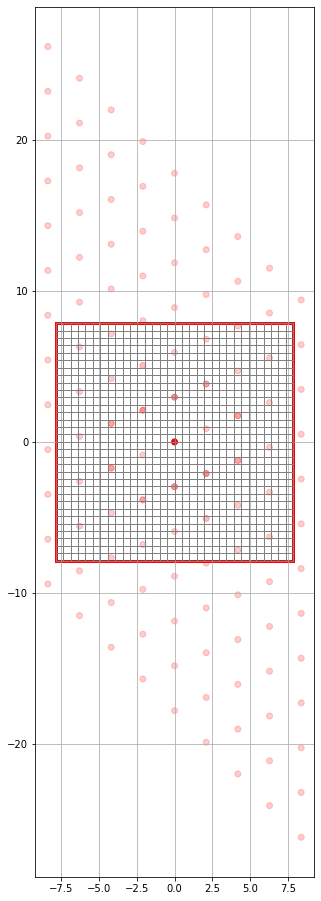

In [11]:
# visualisation of get_mesh_coords
B, G, SG = reciprocal_lattice_gaussian(A, mus, sigma, mx, my)

import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=(16,16))
absSG = np.abs(SG)
colors = [(1.,0.,0.,v) for v in  np.maximum(absSG, absSG.max()*0.2) / absSG.max()]
width = 2*np.pi / L * N
for i in np.linspace(-width/2, width/2, N+1):
    ax.plot([-width/2, width/2],[i, i], color="gray", linewidth=1)
    ax.plot([i, i],[-width/2, width/2], color="gray", linewidth=1)

ax.scatter(G[0,:], G[1,:], c=colors)
rect = patches.Rectangle((-width/2, -width/2), width, width, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.set_aspect('equal')
#plt.xticks(np.linspace(-width/2, width/2, N+1), rotation = 90)
#plt.yticks(np.linspace(-width/2, width/2, N+1))
plt.grid(True)
plt.show()

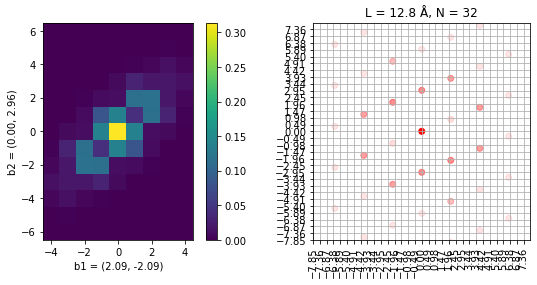

In [12]:
# pass L and N to crop to relevant square 
plot_2D_reciprocal_lattice(B, mx, my, G, SG, L=L, N=N)

In [13]:
# final step:
# place the computed values on a N x N grid
descriptor = make_voxel_grid(G, SG, L, N)

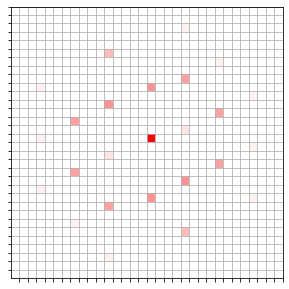

In [14]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
colors = [(1, 1, 1), (1, 0, 0)] # first color is black, last is red
from matplotlib.colors import LinearSegmentedColormap
red_cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=20)
plt.imshow(descriptor, origin='lower', cmap=red_cm)
plt.xticks(np.arange(0,N)+0.5)
plt.yticks(np.arange(0,N)+0.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.grid(True)

In [15]:
# for rotations, get integer ranges such that all points in the desired circle
# of radius width * sqrt(d) / 2 can be computed with reciprocal vectors
# formed with B . (mx x my)
mx, my = get_mesh_coords(A, width*np.sqrt(2))

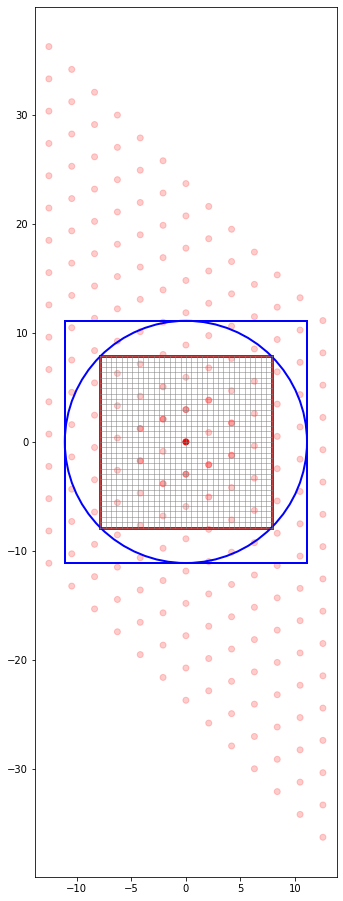

In [16]:
# visualisation of get_mesh_coords
B, G, SG = reciprocal_lattice_gaussian(A, mus, sigma, mx, my)

adj_width = width * np.sqrt(2)

import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=(16,16))
absSG = np.abs(SG)
colors = [(1.,0.,0.,v) for v in  np.maximum(absSG, absSG.max()*0.2) / absSG.max()]

for i in np.linspace(-width/2, width/2, N+1):
    ax.plot([-width/2, width/2],[i, i], color="gray", linewidth=1, alpha=0.5)
    ax.plot([i, i],[-width/2, width/2], color="gray", linewidth=1, alpha=0.5)
    
ax.scatter(G[0,:], G[1,:], c=colors)
width = 2*np.pi / L * N
rect = patches.Rectangle((-width/2, -width/2), width, width, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)
circ = patches.Circle((0.,0.), adj_width / 2,  linewidth=2, edgecolor='b', facecolor='none')
ax.add_patch(circ)
rect = patches.Rectangle((-adj_width/2, -adj_width/2), adj_width, adj_width, linewidth=2, edgecolor='b', facecolor='none')
ax.add_patch(rect)
ax.set_aspect('equal')
plt.grid(False)
plt.show()

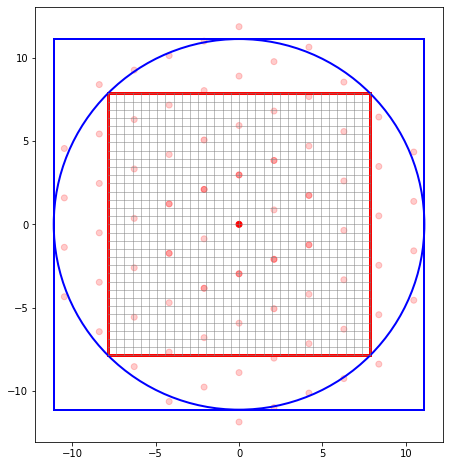

In [17]:
# visualisation of what reduce_data does, removes all reciprocal vector not lying in circle

B, G, SG = reciprocal_lattice_gaussian(A, mus, sigma, mx, my)

width = 2*np.pi / L * N
adj_width = width * np.sqrt(2)

in_grid = np.linalg.norm(G,axis=0) <= adj_width / 2 + 2*width/N # add 2 times voxel width to be sure (rounding)
G = G[:,in_grid]
SG = np.abs(SG[in_grid]) # also convert complex to real her to half the size

import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=(8,8))
absSG = np.abs(SG)
colors = [(1.,0.,0.,v) for v in  np.maximum(absSG, absSG.max()*0.2) / absSG.max()]

for i in np.linspace(-width/2, width/2, N+1):
    ax.plot([-width/2, width/2],[i, i], color="gray", linewidth=1, alpha=0.5)
    ax.plot([i, i],[-width/2, width/2], color="gray", linewidth=1, alpha=0.5)
    
ax.scatter(G[0,:], G[1,:], c=colors)
rect = patches.Rectangle((-width/2, -width/2), width, width, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)
circ = patches.Circle((0.,0.), adj_width / 2,  linewidth=2, edgecolor='b', facecolor='none')
ax.add_patch(circ)
rect = patches.Rectangle((-adj_width/2, -adj_width/2), adj_width, adj_width, linewidth=2, edgecolor='b', facecolor='none')
ax.add_patch(rect)
ax.set_aspect('equal')
plt.grid(False)
plt.show()

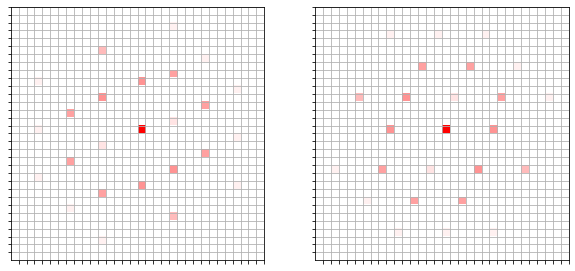

In [18]:
descriptor = make_voxel_grid(G, SG, L, N)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.imshow(descriptor, origin='lower', cmap=red_cm)
ax1.set_xticks(np.arange(0,N)+0.5)
ax1.set_yticks(np.arange(0,N)+0.5)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.grid(True)

R = get_2D_rotation_matrix(np.pi/4) # 45 degress
rotated_descriptor = make_voxel_grid(G, SG, L, N, rot=R)

ax2.imshow(rotated_descriptor, origin='lower', cmap=red_cm)
ax2.set_xticks(np.arange(0,N)+0.5)
ax2.set_yticks(np.arange(0,N)+0.5)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

ax2.grid(True)

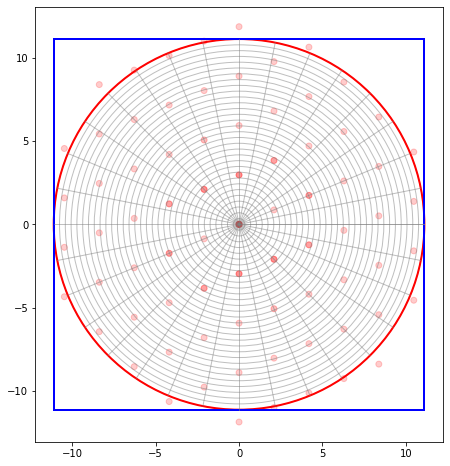

In [19]:
# visualisation of spherical descriptor
B, G, SG = reciprocal_lattice_gaussian(A, mus, sigma, mx, my)


# reduce data
width = 2*np.pi / L * N
adj_width = width * np.sqrt(2)

in_grid = np.linalg.norm(G,axis=0) <= adj_width / 2 + 2*width/N # add 2 times voxel width to be sure (rounding)
G = G[:,in_grid]
SG = np.abs(SG[in_grid]) # also convert complex to real her to half the size

import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=(8,8))
absSG = np.abs(SG)
colors = [(1.,0.,0.,v) for v in  np.maximum(absSG, absSG.max()*0.2) / absSG.max()]


radius = width * np.sqrt(2) / 2
for theta in np.linspace(0, 2*np.pi, N+1):
    ax.plot([0,radius * np.cos(theta)],[0,radius * np.sin(theta)], color="gray", linewidth=1, alpha=0.5)
    
for r in np.linspace(0, radius, N+1):
    circ = patches.Circle((0.,0.), r, edgecolor="gray", linewidth=1, alpha=0.5, facecolor='none')
    ax.add_patch(circ)

ax.scatter(G[0,:], G[1,:], c=colors)

width = 2*np.pi / L * N
circ = patches.Circle((0.,0.), radius,  linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(circ)
rect = patches.Rectangle((-radius, -radius), 2*radius, 2*radius, linewidth=2, edgecolor='b', facecolor='none')
ax.add_patch(rect)
ax.set_aspect('equal')
#plt.xticks(np.linspace(-width/2, width/2, N+1), rotation = 90)
#plt.yticks(np.linspace(-width/2, width/2, N+1))
plt.grid(False)
plt.show()

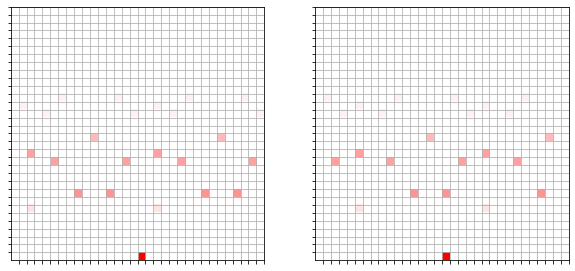

In [20]:
# rotations are horizontal wrapped translations
descriptor = make_spherical_voxel_grid(G, SG, L, N)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.imshow(descriptor, origin='lower', cmap=red_cm)
ax1.set_xticks(np.arange(0,N)+0.5)
ax1.set_yticks(np.arange(0,N)+0.5)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.grid(True)

R = get_2D_rotation_matrix(np.pi/4) # 45 degress
rotated_descriptor = make_spherical_voxel_grid(G, SG, L, N, rot=R)

ax2.imshow(rotated_descriptor, origin='lower', cmap=red_cm)
ax2.set_xticks(np.arange(0,N)+0.5)
ax2.set_yticks(np.arange(0,N)+0.5)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

ax2.grid(True)

## 3D

In [21]:
L = 12.8
N = 32

width = 2 * np.pi / L * N
voxel_width = width / N


A = np.eye(3)
mus =  np.array([[0.,0.,0.]])
sigma = 0.1

mx, my, mz = get_mesh_coords(A, width)

In [22]:
%%time
B, G, SG = reciprocal_lattice_gaussian(A, mus, sigma, mx, my, mz)

CPU times: user 444 µs, sys: 49 µs, total: 493 µs
Wall time: 868 µs


In [23]:
%%time
gauss = get_nD_gaussian(A, mus, sigma, 3)
B2, G2, SG2 = reciprocal_lattice(gauss, A, mx, my, mz, n=61, verbose=True)

Evaluated field at 226981 points in 8.51 seconds.
Performed Fourier Transform in 1.26 seconds.
CPU times: user 4.12 s, sys: 4.02 s, total: 8.15 s
Wall time: 9.83 s


In [24]:
%%time
gauss = get_nD_gaussian(A, mus, sigma, 3)
B3, G3, SG3 = reciprocal_lattice_fft(gauss, A, mx, my, mz, n=61, verbose=True)

Evaluated field at 226981 points in 7.228428840637207 seconds.
Performed Fourier Transform in 0.08 seconds.
CPU times: user 2.83 s, sys: 3.16 s, total: 5.99 s
Wall time: 7.33 s


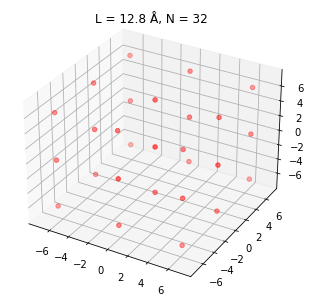

In [25]:
plot_3D_reciprocal_lattice(B, G, SG2, L=L, N=N)

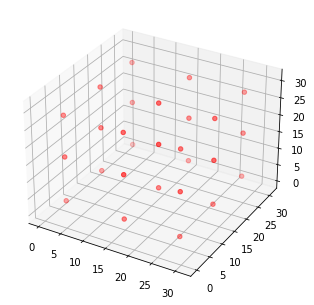

In [26]:
#%matplotlib widget
descriptor = make_voxel_grid(G, SG, L, N)

fig = plt.figure(figsize=(4,4))
ax = Axes3D(fig)

absSG = descriptor.reshape(-1)
max_sg = absSG.max()
colors = [(1.,0.,0.,v) for v in np.maximum(absSG.reshape(-1) / max_sg, 0.0)]
i = np.arange(0, N)
I = np.meshgrid(i, i, i)
ax.scatter(I[0], I[1], I[2], c=colors)
plt.show()

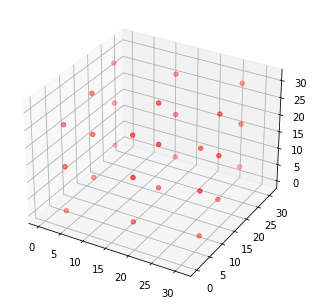

In [27]:
# rotation
mx, my, mz = get_mesh_coords(A, width*np.sqrt(3))
B, G, SG = reciprocal_lattice_gaussian(A, mus, sigma, mx, my, mz)

R = Rotation.from_rotvec([0.,0.,np.pi/16]).as_matrix()

descriptor = make_voxel_grid(G, SG, L, N, rot=R)

fig = plt.figure(figsize=(4,4))
ax = Axes3D(fig)

absSG = descriptor.reshape(-1)
max_sg = absSG.max()
colors = [(1.,0.,0.,v) for v in np.maximum(absSG.reshape(-1) / max_sg, 0.0)]
i = np.arange(0, N)
I = np.meshgrid(i, i, i)
ax.scatter(I[0], I[1], I[2], c=colors)
plt.show()

## Real molecule example

In [28]:
import pandas as pd
o_sr_ti = pd.read_pickle("data/OSrTi.pkl")

from mol_tools import *
from mol_plot import *

In [29]:
mol = o_sr_ti.loc[1]
mol.compound

'O13Sr2Ti6'

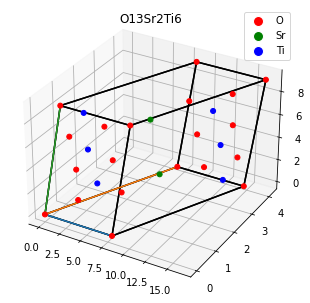

In [30]:
# all atoms in one plane
# %matplotlib widget
plot_3D_crystal(mol)

In [31]:
A = calc_basis(mol.geometry)
A

array([[7.997203  , 7.03294695, 1.4005592 ],
       [0.        , 3.80695587, 0.35474477],
       [0.        , 0.        , 9.16281678]])

In [32]:
# perform rotation to eliminate dimension for better visualisation
v = (A[:,0] + A[:,1])[[0,1]]
v = v / np.linalg.norm(v)
a = np.arccos(v[0])
rot2 = get_2D_rotation_matrix(a)
rot = np.eye(3)
rot[0:2,0:2] = rot2
rot

array([[ 0.96938791, -0.24553428,  0.        ],
       [ 0.24553428,  0.96938791,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [33]:
rot_coords = rot.T.dot(calc_cartesian_positions(A, mol.positions_fractional).T).T
rot_coords

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.65378423e+00, -2.79657919e-15,  6.92850560e+00],
       [ 1.22957867e+01, -7.95253861e-16,  2.23431118e+00],
       [ 2.02733195e+00, -2.62653829e-15,  6.46825154e+00],
       [ 1.49222391e+01, -5.23103550e-16,  2.69456524e+00],
       [ 5.23807370e+00, -1.61976943e-15,  3.94518894e+00],
       [ 1.17114973e+01, -1.73642451e-15,  5.21762784e+00],
       [ 2.46782874e+00, -1.51390116e-15,  3.56100468e+00],
       [ 1.44817422e+01, -2.16856244e-15,  5.60181210e+00],
       [ 5.88068048e+00, -1.35028582e-16,  9.97857228e-01],
       [ 1.10688905e+01, -2.99232351e-15,  8.16495955e+00],
       [ 2.54754075e+00, -3.11369425e-16,  8.64623046e-01],
       [ 1.44020302e+01, -3.20602684e-15,  8.29819378e+00],
       [ 8.12264056e+00, -2.58676530e-15,  7.01800781e+00],
       [ 8.82693039e+00, -1.10092079e-16,  2.14480897e+00],
       [ 3.14199245e+00, -3.36077033e-15,  8.31288929e+00],
       [ 1.38075785e+01,  1.13736362e-17

In [34]:
# new coordinates
mus2 = rot_coords[:, [0,2]]
mus2

array([[ 0.        ,  0.        ],
       [ 4.65378423,  6.9285056 ],
       [12.29578672,  2.23431118],
       [ 2.02733195,  6.46825154],
       [14.92223905,  2.69456524],
       [ 5.2380737 ,  3.94518894],
       [11.71149725,  5.21762784],
       [ 2.46782874,  3.56100468],
       [14.48174221,  5.6018121 ],
       [ 5.88068048,  0.99785723],
       [11.06889047,  8.16495955],
       [ 2.54754075,  0.86462305],
       [14.40203021,  8.29819378],
       [ 8.12264056,  7.01800781],
       [ 8.82693039,  2.14480897],
       [ 3.14199245,  8.31288929],
       [13.8075785 ,  0.84992749],
       [ 3.38865423,  5.16174006],
       [13.56091672,  4.00107672],
       [ 4.03357041,  2.09842358],
       [12.91600055,  7.06439319]])

In [35]:
# new unit cell
az = rot.T.dot(A[:,2])[[0,2]]
A2 = np.array([
    [np.linalg.norm(A[:,0] + A[:,1]), az[0]], 
    [0., az[1]]
])
A2

array([[15.5047838 ,  1.44478716],
       [ 0.        ,  9.16281678]])

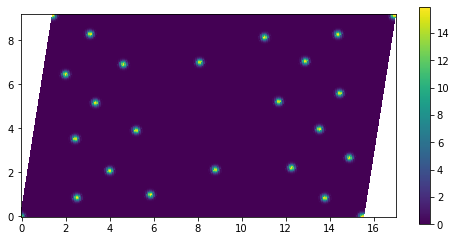

In [36]:
sigma = 0.1
gauss = get_nD_gaussian(A2, mus2, sigma, 3)
R, SR = bravais_lattice(gauss, A2, n=201)
plot_2D_realspace_lattice(A2, R, SR)

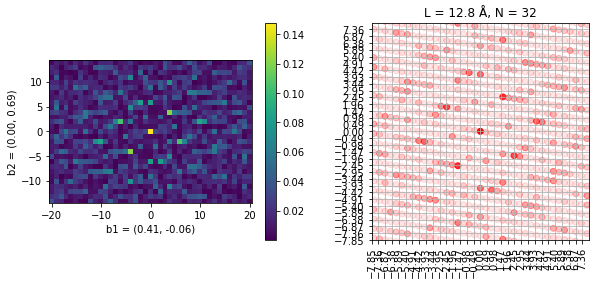

In [37]:
L = 12.8
N = 32

width = 2 * np.pi / L * N

mx, my = get_mesh_coords(A2, width)

B, G, SG = reciprocal_lattice_gaussian(A2, mus2, sigma, mx, my, mz)

plot_2D_reciprocal_lattice(B, mx, my, G, SG, L=L, N=N)

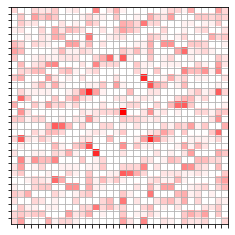

In [38]:
R = get_2D_rotation_matrix(np.pi/4) # 45 degress

# final step:
# place the computed values on a N x N grid
descriptor = make_voxel_grid(G, SG, L, N, rot=np.eye(2))

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
plt.imshow(descriptor, origin='lower', cmap=red_cm)
plt.xticks(np.arange(0,N)+0.5)
plt.yticks(np.arange(0,N)+0.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.grid(True)

## Plots for Report

In [39]:
# matrix corresponding to unit cell (columns are primitive unit vectors)
A = np.array([
    [1., np.sqrt(0.5)],
    [0., np.sqrt(0.5)]
]) * 3

# atom coordinates
mus = np.array([[x1,y1], [x2, y2]])*3

# standard deviation for the Gaussians
sigma = 0.3

# get the field quantity as function
gauss = get_nD_gaussian(A, mus, sigma, 3)

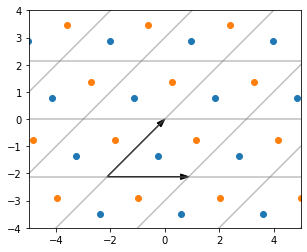

In [40]:
fig, ax = plt.subplots(1)
for n1 in range(-3,4):
    for n2 in range(-3,4):
        v = A.dot(np.array([n1,n2]))
        atom_1 = mus[0,:]
        plt.scatter(atom_1[0] + v[0], atom_1[1] + v[1], c="tab:blue")
        atom_2 = mus[1,:]
        plt.scatter(atom_2[0] + v[0], atom_2[1] + v[1], c="tab:orange")
        

for n1 in range(-3,4):
    v1 = A.dot(np.array([n1,-4]))
    v2 = A.dot(np.array([n1,4]))
    plt.plot([v1[0], v2[0]],[v1[1], v2[1]], c="gray", alpha=0.5)
    
    
    v1 = A.dot(np.array([-4,n1]))
    v2 = A.dot(np.array([4, n1]))
    plt.plot([v1[0], v2[0]],[v1[1], v2[1]], c="gray", alpha=0.5)
    
    
v1 = A.dot(np.array([0,-1]))
v2 = A.dot(np.array([0, 0]))
plt.arrow(v1[0], v1[0], v2[0]-v1[0], v2[1]-v1[1], color="black", head_width=0.2, length_includes_head=True)

v1 = A.dot(np.array([0,-1]))
v2 = A.dot(np.array([1, -1]))
plt.arrow(v1[0], v1[0], v2[0]-v1[0], v2[1]-v1[1], color="black", head_width=0.2, length_includes_head=True)
    
plt.xlim((-5,5))
plt.ylim((-4,4))
ax.set_aspect("equal")
plt.savefig("figs/unit_cell.pdf")

In [41]:
n = 1000
x1, x2 = np.meshgrid(np.linspace(-3,3,n), np.linspace(-3,3,n))
X = np.vstack((x1.reshape(1,-1), x2.reshape(1,-1)))

R = A.dot(X)
SR = gauss(R)
SR = SR.reshape(n,n)

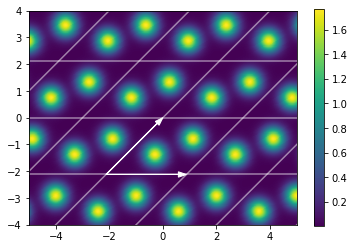

In [42]:
r1 = R[0,:].reshape(n,n)
r2 = R[1,:].reshape(n,n)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
plt.pcolormesh(r1, r2, SR, shading='auto')   

plt.colorbar()
plt.xlim((-5,5))
plt.ylim((-4,4))

for n1 in range(-3,4):
    v1 = A.dot(np.array([n1,-4]))
    v2 = A.dot(np.array([n1,4]))
    plt.plot([v1[0], v2[0]],[v1[1], v2[1]], c="white", alpha=0.5)
    
    
    v1 = A.dot(np.array([-4,n1]))
    v2 = A.dot(np.array([4, n1]))
    plt.plot([v1[0], v2[0]],[v1[1], v2[1]], c="white", alpha=0.5)
    
v1 = A.dot(np.array([0,-1]))
v2 = A.dot(np.array([0, 0]))
plt.arrow(v1[0], v1[0], v2[0]-v1[0], v2[1]-v1[1], color="white", head_width=0.2, length_includes_head=True)

v1 = A.dot(np.array([0,-1]))
v2 = A.dot(np.array([1, -1]))
plt.arrow(v1[0], v1[0], v2[0]-v1[0], v2[1]-v1[1], color="white", head_width=0.2, length_includes_head=True)
    
    
#plt.show()
plt.savefig("figs/unit_cell_gauss.png")

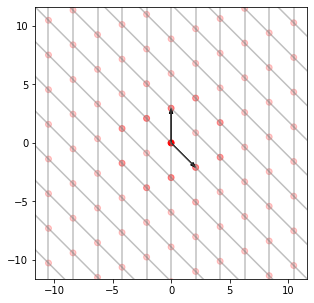

In [43]:
# visualisation of get_mesh_coords
B, G, SG = reciprocal_lattice_gaussian(A, mus, sigma, mx, my)

import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=(5,5))
absSG = np.abs(SG)
colors = [(1.,0.,0.,v) for v in  np.maximum(absSG, absSG.max()*0.2) / absSG.max()]

ax.scatter(G[0,:], G[1,:], c=colors)


for n1 in range(-10,11):
    v1 = B.dot(np.array([n1,-10]))
    v2 = B.dot(np.array([n1,10]))
    plt.plot([v1[0], v2[0]],[v1[1], v2[1]], c="gray", alpha=0.5)
    
    
    v1 = B.dot(np.array([-10,n1]))
    v2 = B.dot(np.array([10, n1]))
    plt.plot([v1[0], v2[0]],[v1[1], v2[1]], c="gray", alpha=0.5)
    
    
v1 = B.dot(np.array([0,-1]))
v2 = B.dot(np.array([0, 0]))
plt.arrow(v1[0], v1[0], v2[0]-v1[0], v2[1]-v1[1], color="black", head_width=0.3, length_includes_head=True)

v1 = B.dot(np.array([0,-1]))
v2 = B.dot(np.array([1, -1]))
plt.arrow(v1[0], v1[0], v2[0]-v1[0], v2[1]-v1[1], color="black", head_width=0.3, length_includes_head=True)

ax.set_aspect('equal')
#plt.xticks(np.linspace(-width/2, width/2, N+1), rotation = 90)
#plt.yticks(np.linspace(-width/2, width/2, N+1))
plt.grid(False)
plt.xlim((-width* np.sqrt(2)/2 - 0.5, width* np.sqrt(2)/2 + 0.5))
plt.ylim((-width* np.sqrt(2)/2 - 0.5, width* np.sqrt(2)/2 + 0.5))
plt.savefig("figs/reciprocal.pdf")

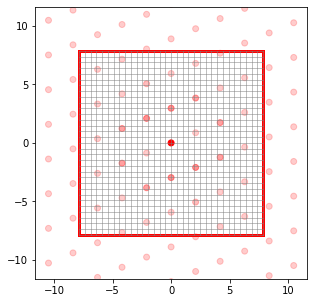

In [44]:
# visualisation of get_mesh_coords
B, G, SG = reciprocal_lattice_gaussian(A, mus, sigma, mx, my)

import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=(5,5))
absSG = np.abs(SG)
colors = [(1.,0.,0.,v) for v in  np.maximum(absSG, absSG.max()*0.2) / absSG.max()]

for i in np.linspace(-width/2, width/2, N+1):
    ax.plot([-width/2, width/2],[i, i], color="gray", linewidth=1, alpha=0.5)
    ax.plot([i, i],[-width/2, width/2], color="gray", linewidth=1, alpha=0.5)
    
ax.scatter(G[0,:], G[1,:], c=colors)
width = 2*np.pi / L * N
rect = patches.Rectangle((-width/2, -width/2), width, width, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)
circ = patches.Circle((0.,0.), width * np.sqrt(2) / 2,  linewidth=2, edgecolor='b', facecolor='none')
#ax.add_patch(circ)
ax.set_aspect('equal')
#plt.xticks(np.linspace(-width/2, width/2, N+1), rotation = 90)
#plt.yticks(np.linspace(-width/2, width/2, N+1))
plt.grid(False)
plt.xlim((-width* np.sqrt(2)/2 - 0.5, width* np.sqrt(2)/2 + 0.5))
plt.ylim((-width* np.sqrt(2)/2 - 0.5, width* np.sqrt(2)/2 + 0.5))
plt.savefig("figs/cartesian_descriptor.pdf")

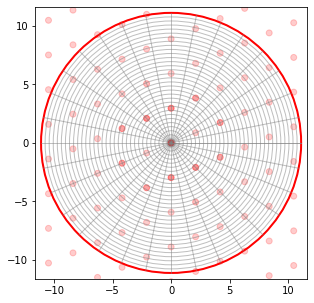

In [45]:
# visualisation of get_mesh_coords
B, G, SG = reciprocal_lattice_gaussian(A, mus, sigma, mx, my)

import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=(5,5))
absSG = np.abs(SG)
colors = [(1.,0.,0.,v) for v in  np.maximum(absSG, absSG.max()*0.2) / absSG.max()]


radius = width * np.sqrt(2) / 2
for theta in np.linspace(0, 2*np.pi, N+1):
    ax.plot([0,radius * np.cos(theta)],[0,radius * np.sin(theta)], color="gray", linewidth=1, alpha=0.5)
    
for r in np.linspace(0, radius, N+1):
    circ = patches.Circle((0.,0.), r, edgecolor="gray", linewidth=1, alpha=0.5, facecolor='none')
    ax.add_patch(circ)

ax.scatter(G[0,:], G[1,:], c=colors)

width = 2*np.pi / L * N
circ = patches.Circle((0.,0.), radius,  linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(circ)
ax.set_aspect('equal')
#plt.xticks(np.linspace(-width/2, width/2, N+1), rotation = 90)
#plt.yticks(np.linspace(-width/2, width/2, N+1))
plt.grid(False)
plt.xlim((-width* np.sqrt(2)/2 - 0.5, width* np.sqrt(2)/2 + 0.5))
plt.ylim((-width* np.sqrt(2)/2 - 0.5, width* np.sqrt(2)/2 + 0.5))
plt.savefig("figs/spherical_descriptor.pdf")